In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
os.environ["WORLD_SIZE"] = "4"

import torch
import flashinfer
import time
import random
from tqdm.auto import tqdm
import gc

In [2]:
qkv_lens = [32, 64, 128, 256, 512, 1024, 2048]
num_kv_heads = 32
num_qo_heads = 32
head_dim = 4096 // num_qo_heads


In [3]:
def run_api(qkv_len, runs=1, dtype=torch.float16):

    k = torch.randn(qkv_len, num_kv_heads, head_dim, dtype=dtype).to(0)
    v = torch.randn(qkv_len, num_kv_heads, head_dim, dtype=dtype).to(0)
    q = torch.randn(qkv_len, num_qo_heads, head_dim, dtype=dtype).to(0)

    start = time.time()
    for j in range(runs):
        o1 = flashinfer.single_prefill_with_kv_cache(q, k, v, causal=True, allow_fp16_qk_reduction=True)
    end = time.time()
    t1 = end - start

    # k = torch.randn(qkv_len, num_kv_heads, head_dim, dtype=dtype).to(0)
    # v = torch.randn(qkv_len, num_kv_heads, head_dim, dtype=dtype).to(0)
    # q = torch.randn(qkv_len, num_qo_heads, head_dim, dtype=dtype).to(0)

    start = time.time()
    for j in range(runs):
        o2 = flashinfer.single_prefill_with_kv_cache(q, k, v, causal=True, allow_fp16_qk_reduction=False)
    end = time.time()
    t2 = end - start

    return t1, t2, (o1 - o2).abs().mean().item(), (o1 - o2).abs().max().item()
    

In [4]:
for qkv_len in qkv_lens:
    t1, t2, mean_, max_ = run_api(qkv_len, 10000, dtype=torch.float16)
    speedup = (t2 - t1) / t2
    print(f"{qkv_len=}: {speedup=}, mean_diff={mean_}, max_diff={max_}")


qkv_len=32: speedup=-0.018992333659336846, mean_diff=0.00018274784088134766, max_diff=0.00390625
qkv_len=64: speedup=-0.01194530290250211, mean_diff=0.00016736984252929688, max_diff=0.00341796875
qkv_len=128: speedup=-0.14447179516707934, mean_diff=0.00014770030975341797, max_diff=0.003448486328125
qkv_len=256: speedup=0.2221012426789369, mean_diff=0.0001226663589477539, max_diff=0.0048828125
qkv_len=512: speedup=0.18597702570035554, mean_diff=9.971857070922852e-05, max_diff=0.0029296875
qkv_len=1024: speedup=0.28105062100291733, mean_diff=7.706880569458008e-05, max_diff=0.00390625
qkv_len=2048: speedup=0.28540420183434256, mean_diff=5.894899368286133e-05, max_diff=0.0045166015625


In [5]:
def run_api(q, k, v, runs=1, reduction=False):

    start = time.time()
    for j in range(runs):
        o1 = flashinfer.single_prefill_with_kv_cache(q, k, v, causal=True, allow_fp16_qk_reduction=reduction)
    end = time.time()
    t1 = end - start

    return t1


In [7]:
dtype=torch.float16

for qkv_len in qkv_lens:
    
    k = torch.randn(qkv_len, num_kv_heads, head_dim, dtype=dtype).to(0)
    v = torch.randn(qkv_len, num_kv_heads, head_dim, dtype=dtype).to(0)
    q = torch.randn(qkv_len, num_qo_heads, head_dim, dtype=dtype).to(0)

    t1 = run_api(q, k, v, runs=100000, reduction=False)

    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

    t2 = run_api(q, k, v, runs=100000, reduction=True)
    speedup = (t1 - t2) / t1

    print(f"{qkv_len=}, {speedup=}")

qkv_len=32, speedup=0.05105076402910359
qkv_len=64, speedup=0.14443485986820326
qkv_len=128, speedup=0.10473477582164228
qkv_len=256, speedup=0.1473141128982919
qkv_len=512, speedup=0.1487042682298998
qkv_len=1024, speedup=0.2162805642492188
qkv_len=2048, speedup=0.2208005014862723


In [8]:
dtype=torch.bfloat16

for qkv_len in qkv_lens:
    
    k = torch.randn(qkv_len, num_kv_heads, head_dim, dtype=dtype).to(0)
    v = torch.randn(qkv_len, num_kv_heads, head_dim, dtype=dtype).to(0)
    q = torch.randn(qkv_len, num_qo_heads, head_dim, dtype=dtype).to(0)

    t1 = run_api(q, k, v, runs=100000, reduction=False)

    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

    t2 = run_api(q, k, v, runs=100000, reduction=True)
    speedup = (t1 - t2) / t1

    print(f"{qkv_len=}, {speedup=}")

qkv_len=32, speedup=0.0038961234341139714
qkv_len=64, speedup=0.02968430813551595
qkv_len=128, speedup=-0.00014365647913785025
qkv_len=256, speedup=-3.774175362340492e-05
qkv_len=512, speedup=-0.0010538245640938206
qkv_len=1024, speedup=-0.00012614613207970304
qkv_len=2048, speedup=0.00015459003787195082


In [12]:
num_qo_heads = 32
hidden_size = 4096
num_kv_heads = 8
head_dim = hidden_size // num_qo_heads
max_num_pages = 128
page_size = 16

In [13]:
def get_random_cfg(nnz_qo=1024, batch_size=2, dtype=torch.float16):

    qo_indptr = list(range(1, nnz_qo))
    random.shuffle(qo_indptr)
    qo_indptr = sorted(qo_indptr[:batch_size - 1])
    qo_indptr = torch.tensor([0] + qo_indptr + [nnz_qo], dtype=torch.int32, device="cuda:0") 
    # [0, 33, 44, 55, 66, 77, 88, nnz_qo]

    paged_kv_indices = torch.arange(max_num_pages).int().to("cuda:0")

    paged_kv_indptr = list(range(1, max_num_pages))
    random.shuffle(paged_kv_indptr)
    paged_kv_indptr = sorted(paged_kv_indptr[:batch_size - 1])
    paged_kv_indptr = torch.tensor([0] + paged_kv_indptr + [max_num_pages], dtype=torch.int32, device="cuda:0")
    # [0, 17, 29, 44, 48, 66, 100, 128]

    # 1 <= paged_kv_last_page_len <= page_size
    paged_kv_last_page_len = torch.randint(1, page_size + 1, [batch_size], dtype=torch.int32, device="cuda:0")
    # [1, 7, 14, 4, 3, 1, 16]

    q = torch.randn(nnz_qo, num_qo_heads, head_dim, dtype=dtype).to("cuda:0")
    kv_cache = torch.randn(
        max_num_pages, 2, page_size, num_kv_heads, head_dim, dtype=dtype, device="cuda:0"
    )

    return {
        "plan": {
            "qo_indptr": qo_indptr,
            "paged_kv_indices": paged_kv_indices,
            "paged_kv_indptr": paged_kv_indptr,
            "paged_kv_last_page_len": paged_kv_last_page_len
        },
        "run": {
            "q": q,
            "paged_kv_cache": kv_cache
        }

    }


In [14]:

def run_wrapper(cfg, reduction=False, runs=10000):

    # allocate 128MB workspace buffer
    workspace_buffer = torch.empty(128 * 1024 * 1024, dtype=torch.uint8, device="cuda:0")
    prefill_wrapper = flashinfer.BatchPrefillWithPagedKVCacheWrapper(
        workspace_buffer, "NHD"
    )
    
    start = time.time()
    # create auxiliary data structures for batch prefill attention
    prefill_wrapper.plan(
        **cfg['plan'],
        num_qo_heads=num_qo_heads,
        num_kv_heads=num_kv_heads,
        head_dim=head_dim,
        page_size=page_size,
        causal=True,
        allow_fp16_qk_reduction=reduction
    )
    
    # compute batch prefill attention, reuse auxiliary data structures
    for i in range(runs):
        o = prefill_wrapper.run(**cfg['run'])

    end = time.time()
    return end - start, o



In [15]:
qkv_lens = [32, 64, 128, 256, 512, 1024, 2048]

for q_len in qkv_lens:
    cfg = get_random_cfg(nnz_qo=q_len, dtype=torch.bfloat16)

    t1, o1 = run_wrapper(cfg, reduction=False, runs=100000)

    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

    t2, o2 = run_wrapper(cfg, reduction=True, runs=100000)
    
    speedup = ((t1 - t2) / t1)
    max_diff = (o1 - o2).abs().max().item()
    mean_diff = (o1 - o2).abs().mean().item()
    print(f"{q_len=}, {speedup=}, {max_diff=}, {mean_diff}")

q_len=32, speedup=0.007146227406085566, max_diff=0.0, 0.0
q_len=64, speedup=-3.92106637242249e-05, max_diff=0.0, 0.0
q_len=128, speedup=-0.0012294409764959002, max_diff=0.0, 0.0
q_len=256, speedup=-7.896748570532046e-05, max_diff=0.0, 0.0
q_len=512, speedup=0.004146915845127964, max_diff=0.0, 0.0
q_len=1024, speedup=-0.00018547874697888856, max_diff=0.0, 0.0
q_len=2048, speedup=3.142248686604646e-05, max_diff=0.0, 0.0


In [19]:
qkv_lens = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

for q_len in qkv_lens:
    cfg = get_random_cfg(nnz_qo=q_len, dtype=torch.float16)

    t1, o1 = run_wrapper(cfg, reduction=False, runs=100000)

    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

    t2, o2 = run_wrapper(cfg, reduction=True, runs=100000)

    speedup = ((t1 - t2) / t1)
    max_diff = (o1 - o2).abs().max().item()
    mean_diff = (o1 - o2).abs().mean().item()
    print(f"{q_len=}, {speedup=}, {max_diff=}, {mean_diff}")

q_len=32, speedup=0.087164235846492, max_diff=0.00164794921875, 8.684396743774414e-05
q_len=64, speedup=0.12089284439473622, max_diff=0.0010986328125, 4.845857620239258e-05
q_len=128, speedup=0.15299789633745817, max_diff=0.001708984375, 4.756450653076172e-05
q_len=256, speedup=0.1520159062362263, max_diff=0.001953125, 5.739927291870117e-05
q_len=512, speedup=0.16294965707087203, max_diff=0.001953125, 4.547834396362305e-05
q_len=1024, speedup=0.2046512707120729, max_diff=0.00244140625, 6.16312026977539e-05
q_len=2048, speedup=0.2113029920444161, max_diff=0.00390625, 5.167722702026367e-05
q_len=4096, speedup=0.20356018519135768, max_diff=0.00341796875, 4.547834396362305e-05
q_len=8192, speedup=0.2012746153481013, max_diff=0.00439453125, 2.5093555450439453e-05


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

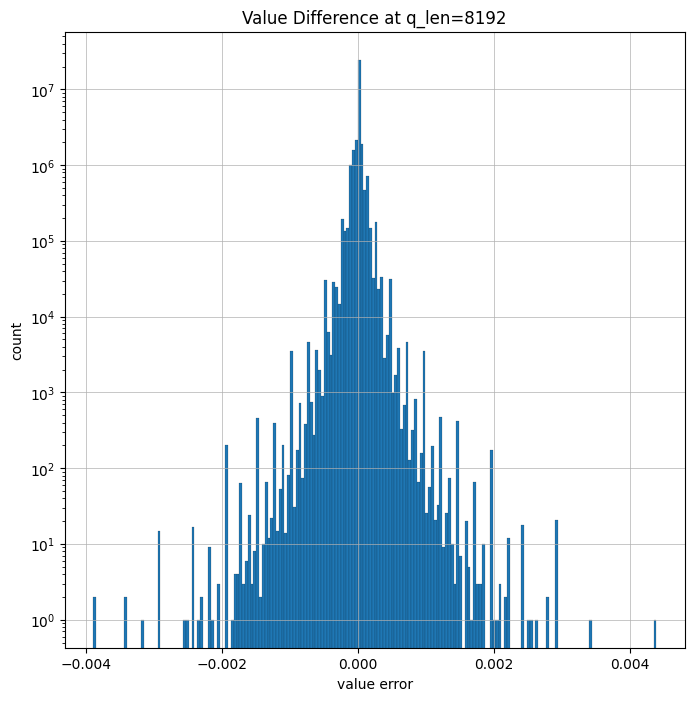

In [23]:
fig = plt.figure(figsize=(8, 8))
_ = plt.hist((o1 - o2).flatten().cpu().numpy(), bins=200, density=False, edgecolor='black', linewidth=0.1)
plt.yscale('log')
plt.grid(linewidth=0.5)
plt.title('Value Difference at q_len=8192')
plt.xlabel('value error')
plt.ylabel('count')
plt.show()

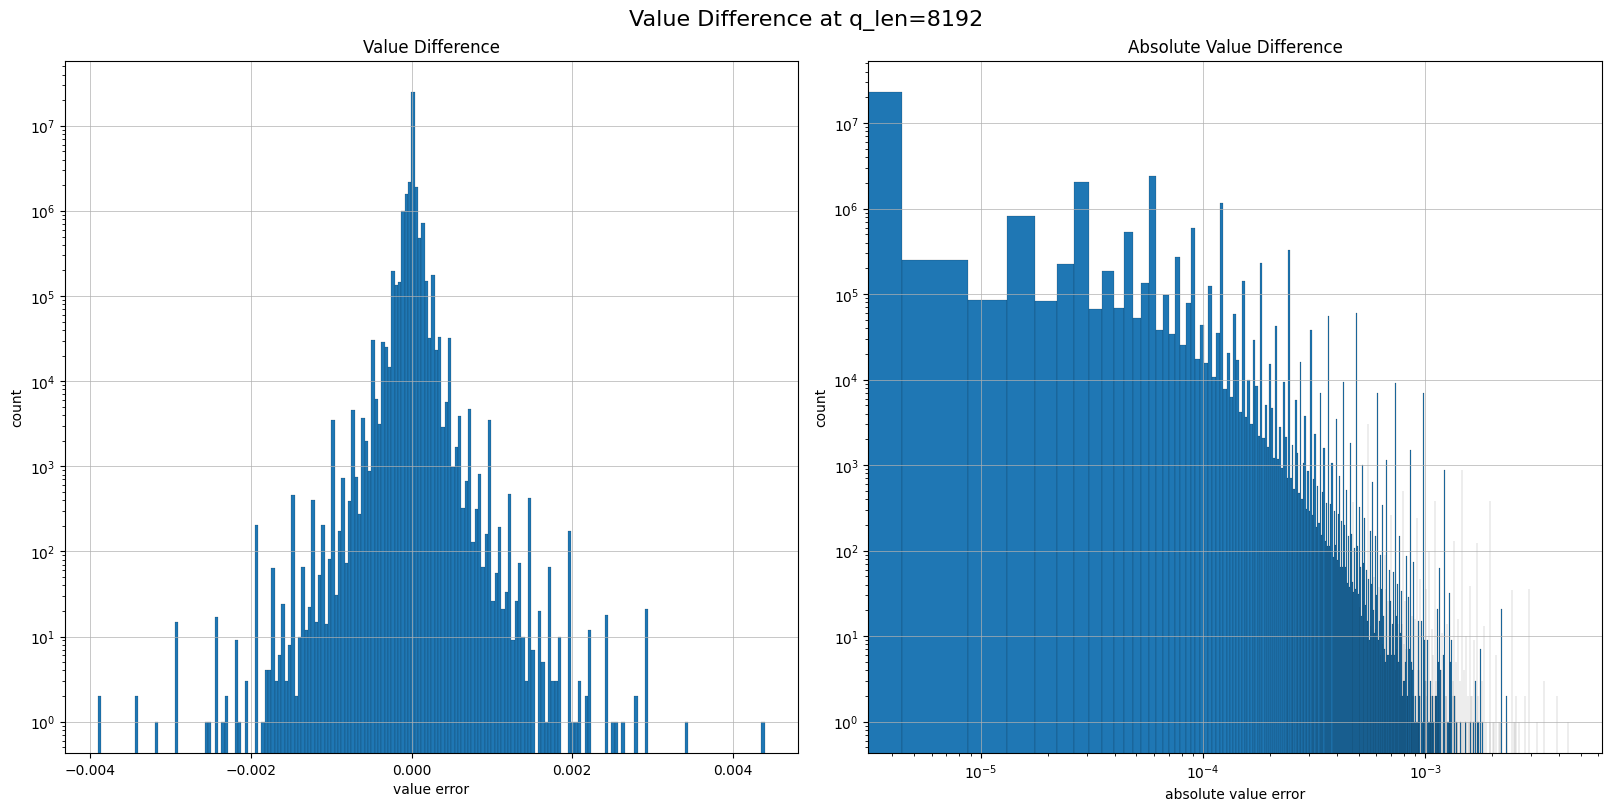

In [26]:
import matplotlib.pyplot as plt

# 创建一个包含两幅子图的画布
fig, axes = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

# 绘制第一幅图：o1 - o2 的直方图
axes[0].hist((o1 - o2).flatten().cpu().numpy(), bins=200, density=False, edgecolor='black', linewidth=0.1)
axes[0].set_yscale('log')
axes[0].grid(linewidth=0.5)
axes[0].set_title('Value Difference')
axes[0].set_xlabel('value error')
axes[0].set_ylabel('count')

# 绘制第二幅图：o1 - o2 的绝对值直方图，x轴使用对数尺度
axes[1].hist((o1 - o2).abs().flatten().cpu().numpy(), bins=1000, density=False, edgecolor='black', linewidth=0.1)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(linewidth=0.5)
axes[1].set_title('Absolute Value Difference')
axes[1].set_xlabel('absolute value error')
axes[1].set_ylabel('count')

# 设置整个图的标题
fig.suptitle('Value Difference at q_len=8192', fontsize=16)

# 显示图像
plt.show()
